## Modeling Notebook

In [1]:
import pandas as pd
import yfinance as yf
from yahooquery import Ticker
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [2]:
# Reading in most recent data
stock_data = pd.read_csv('data/RevandEbitda.csv')
stock_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
stock_data.head()

,Ticker,AveragePriceTarget,NumRatings,ClosingPrice,MarketCap,ExpectedGrowthRate,OverallRecommendation,ProjectedMarketCap,TotalRevenue,NormEBITDA
0,A,166.50,14,138.09,4.088458e+10,0.206,0,4.930681e+10,6.848000e+09,1.985000e+09
1,AA,50.00,11,39.43,7.032538e+09,0.268,1,8.917258e+09,1.245100e+10,2.142000e+09
2,AADI,37.00,3,7.20,1.756447e+08,4.139,1,9.026382e+08,1.000000e+06,-3.535800e+07
3,AAL,16.62,14,13.89,1.862496e+10,0.197,0,2.229408e+10,4.897100e+10,1.423200e+10
4,AAN,16.00,5,9.54,2.936460e+08,0.677,1,4.924443e+08,2.249434e+09,7.345500e+08


We're now ready to set up our first model

In [27]:
first_model_df = stock_data[['Ticker', 'TotalRevenue', 'NormEBITDA','OverallRecommendation']]
first_model_df.set_index('Ticker', inplace = True)

In [28]:
X = first_model_df.drop(['OverallRecommendation'], axis = 1)
y = first_model_df['OverallRecommendation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4, random_state= 42)

In [52]:
smt = SMOTE(random_state = 42)
ss = StandardScaler()
rfc = RandomForestClassifier(random_state = 42)
rfc_pipeline = Pipeline([('smote', smt),('scaler', ss),('random_forest',rfc)])

0.5363777089783281


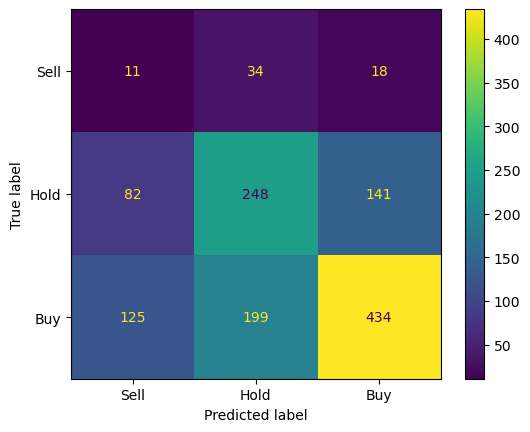

In [7]:
rfc_pipeline.fit(X_train, y_train)
y_pred = rfc_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
ConfusionMatrixDisplay(cm, display_labels= ['Sell','Hold','Buy']).plot()

Hyper Parameter Tuning

In [58]:
rfc_params = {'random_forest__max_depth': [1,2,3,4,5,6], 'random_forest__n_estimators': [15,20,25,30,35]}

In [59]:
gs = GridSearchCV(rfc_pipeline, rfc_params, cv = 5, scoring = 'accuracy', verbose = 1)
gs.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('random_forest',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'random_forest__max_depth': [1, 2, 3, 4, 5, 6],
                         'random_forest__n_estimators': [15, 20, 25, 30, 35]},
             scoring='accuracy', verbose=1)

In [60]:
gs.best_params_

{'random_forest__max_depth': 1, 'random_forest__n_estimators': 25}

In [61]:
gs.best_score_

0.5950238418711208

Updating Parameters

In [63]:
rfc = RandomForestClassifier(max_depth = 1, n_estimators = 25, random_state = 42)
rfc_pipeline = Pipeline([('smote', smt),('scaler', ss),('random_forest',rfc)])

0.6578947368421053


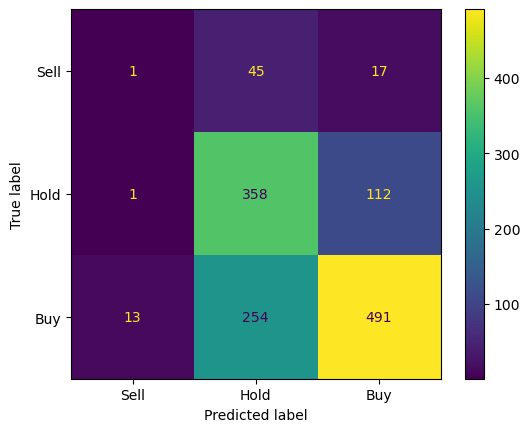

In [64]:
rfc_pipeline.fit(X_train, y_train)
y_pred = rfc_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
ConfusionMatrixDisplay(cm, display_labels= ['Sell','Hold','Buy']).plot()